In [176]:
from astropy.table import Table
from astropy.io import fits
from astropy import wcs
import os
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt 
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import grizli.utils
from glob import glob
import grizli.model
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
from time import time
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

# Get list of all objects

In [3]:
goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

if hpath == '/Users/Vince.ec/':
    catpath = hpath
else:
    catpath='/Users/vestrada/Desktop/'

restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()

fast_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
fast_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()

eazy_s = Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()
eazy_n = Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout',
               format = 'ascii').to_pandas()


In [4]:
IDS=[]
IDN=[]

for i in range(len(restc_s['id'])):
    if eazy_s.z_spec[i] != -1:
        rshift = eazy_s.z_spec[i]
    else: 
        rshift = eazy_s.z_peak[i]

    if 0.8<= rshift <= 2.0 and goods_s['class_star'][i]<0.8 and fast_s['lmass'][i] >= 10:
        IDS.append(i)

for i in range(len(restc_n['id'])):
    if eazy_n.z_spec[i] != -1:
        rshift = eazy_n.z_spec[i]
    else: 
        rshift = eazy_n.z_peak[i]

    if 0.8<= rshift <= 2.0 and goods_n['class_star'][i]<0.8 and fast_n['lmass'][i] >= 10:
        IDN.append(i)


In [5]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)
uvN=Mag(restc_n['L153'][IDN].values) - Mag(restc_n['L155'][IDN].values)
vjN=Mag(restc_n['L155'][IDN].values) - Mag(restc_n['L161'][IDN].values)


IDSQ=[]
IDSsf=[]

IDNQ=[]
IDNsf=[]


for i in range(len(uvS)):
    if uvS[i]>=0.88*vjS[i]+0.59 and uvS[i]>1.382 and vjS[i]<1.65:
        IDSQ.append(i)
    if uvS[i]<0.88*vjS[i]+0.59:
        IDSsf.append(i)
        
for i in range(len(uvN)):
    if uvN[i]>=0.88*vjN[i]+0.59 and uvN[i]>1.382 and vjN[i]<1.65:
        IDNQ.append(i)
    if uvN[i]<0.88*vjN[i]+0.59:
        IDNsf.append(i)

No handles with labels found to put in legend.


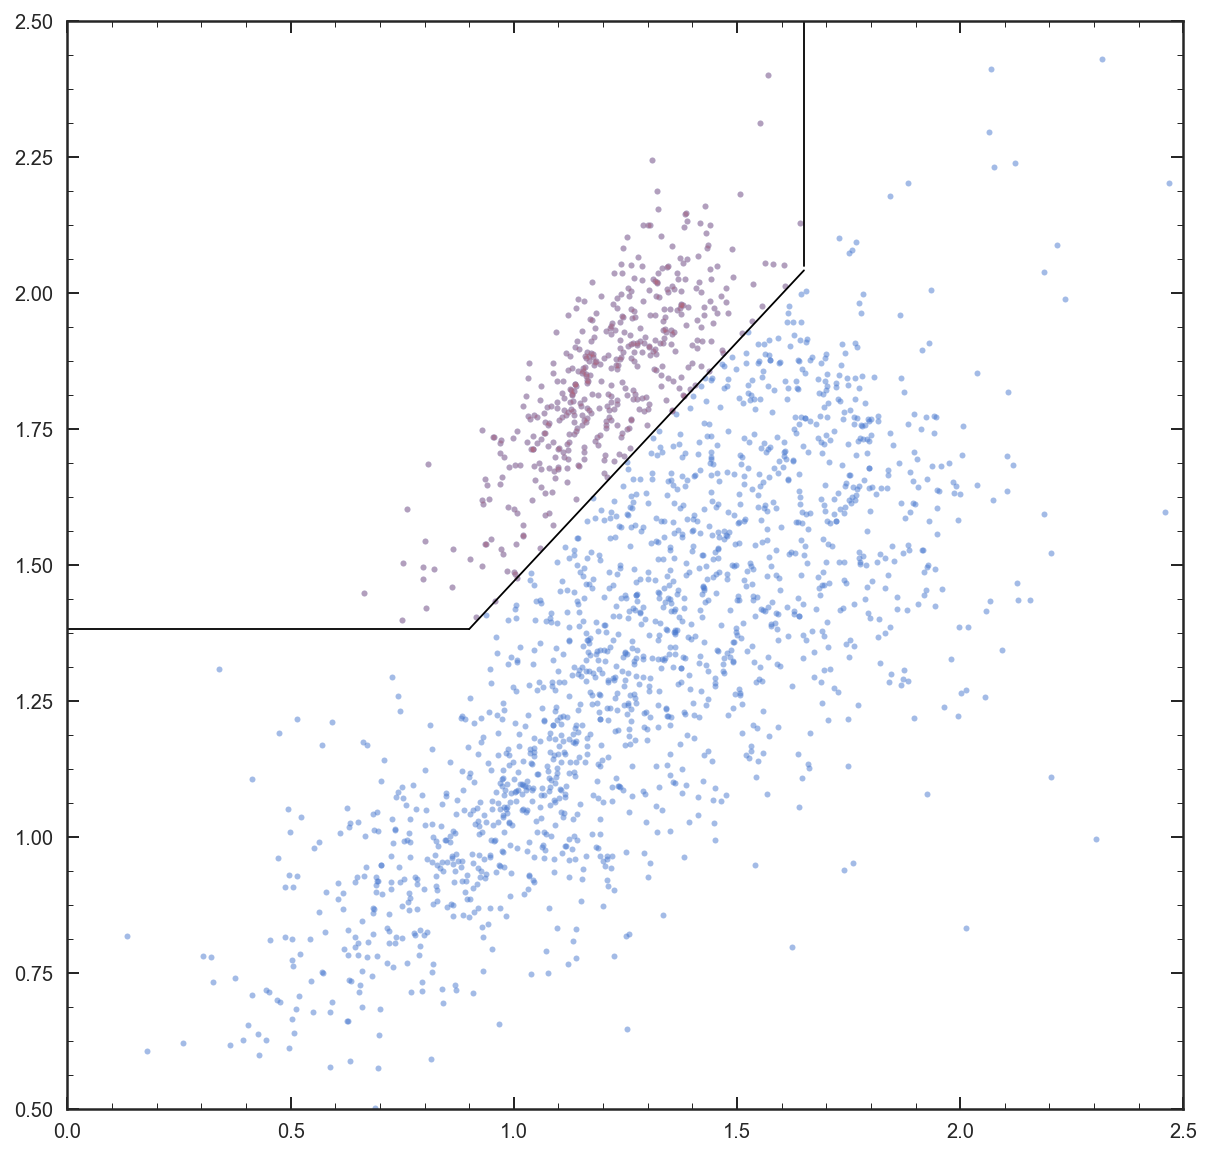

In [6]:
plt.figure(figsize=[10,10])
plt.plot(vjS,uvS,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjN,uvN,'o',color=sea.color_palette('muted')[0], alpha=.5,ms=3)
plt.plot(vjS[IDSQ],uvS[IDSQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot(vjN[IDNQ],uvN[IDNQ],'o',color=sea.color_palette('muted')[2], alpha=.3,ms=3)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()

In [9]:
s_cand =pd.DataFrame({ 'gids' : eazy_s.id[np.array(IDS)[np.array(IDSQ)]],
    'zspec' : eazy_s.z_spec[np.array(IDS)[np.array(IDSQ)]],
    'zphot' : eazy_s.z_peak[np.array(IDS)[np.array(IDSQ)]],
    'ra' : goods_s.ra[np.array(IDS)[np.array(IDSQ)]],
    'dec' : goods_s.dec[np.array(IDS)[np.array(IDSQ)]],
    'in_out' : np.repeat('out',len(IDSQ))})

n_cand =pd.DataFrame({ 'gids' : eazy_n.id[np.array(IDN)[np.array(IDNQ)]],
    'zspec' : eazy_n.z_spec[np.array(IDN)[np.array(IDNQ)]],
    'zphot' : eazy_n.z_peak[np.array(IDN)[np.array(IDNQ)]],
    'ra' : goods_n.ra[np.array(IDN)[np.array(IDNQ)]],
    'dec' : goods_n.dec[np.array(IDN)[np.array(IDNQ)]],
    'in_out' : np.repeat('out',len(IDNQ))})

# Filter using Source Present with wider limits

In [8]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 <pos[0]< xpixlim + 100  and -100 < pos[1] < ypixlim + 100 and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [12]:
filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
for i in s_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand.ra[i],s_cand.dec[i])
        if pres == True:
            s_cand.in_out[i]= 'in'
            break
            
filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
for i in n_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand.ra[i],n_cand.dec[i])
        if pres == True:
            n_cand.in_out[i]= 'in'
            break

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
s_cand = s_cand.query('in_out == "in"')
n_cand = n_cand.query('in_out == "in"')

In [17]:
s_cand.to_pickle('../data/s_candidates.pkl')
n_cand.to_pickle('../data/n_candidates.pkl')

# Filter AGN

In [18]:
agn_ra=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_RA']
agn_dec=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_DEC']

In [19]:
def Match_agn(gal_ra, gal_dec, agn_ra, agn_dec):
    r = (1. / 60 / 60) * 1    
    in_out = np.repeat('in',len(gal_ra))          
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(agn_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(agn_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(agn_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                in_out[i]= 'out'
    return in_out

In [21]:
south_agn = Match_agn(s_cand['ra'].values,s_cand['dec'].values,agn_ra,agn_dec)

In [22]:
n_agn_cat=Table.read('../../../Clear_data/AGN_catalog/apjs523032t3_mrt.txt',format='ascii')

In [23]:
RA=np.array([n_agn_cat['RAh'].data, n_agn_cat['RAm'].data,n_agn_cat['RAs'].data]).T
DEC=np.array([n_agn_cat['DEd'].data,n_agn_cat['DEm'].data,n_agn_cat['DEs'].data]).T

def Convert_RA_DEC_to_deg(ra,dec):
    R=15*(ra[0]+ra[1]/60.+ra[2]/3600.)
    D=dec[0]+dec[1]/60.+dec[2]/3600.
    return R,D

nra,ndec=np.zeros([2,len(RA)])

for i in range(len(RA)):
    nra[i],ndec[i]=Convert_RA_DEC_to_deg(RA[i],DEC[i])

In [24]:
north_agn = Match_agn(n_cand['ra'].values,n_cand['dec'].values,nra,ndec)

In [25]:
s_cand.in_out = south_agn
n_cand.in_out = north_agn

In [27]:
s_cand = s_cand.query('in_out == "in"')
n_cand = n_cand.query('in_out == "in"')

In [32]:
s_cand.to_pickle('../data/s_candidates.pkl')
n_cand.to_pickle('../data/n_candidates.pkl')

# Filter using grism flt

In [104]:
s_field = np.repeat('out',len(s_cand))
n_field = np.repeat('out',len(n_cand))

In [105]:
files = glob(hpath + 'Clear_data/test/*flt.fits')
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)
os.chdir(hpath + 'Clear_data/test')

ERSPRIME-cxt-20-092.0-F105W 2
ERSPRIME-cxt-21-092.0-F105W 2
ERSPRIME-cxt-19-122.0-F105W 2
ERSPRIME-cxt-22-142.0-F105W 2
ERSPRIME-cxt-23-142.0-F105W 2
ERSPRIME-cxt-20-092.0-G102 4
ERSPRIME-cxt-21-092.0-G102 4
ERSPRIME-cxt-19-122.0-G102 4
ERSPRIME-cxt-22-142.0-G102 4
ERSPRIME-cxt-23-142.0-G102 4
GN1-cxt-47-153.0-F105W 2
GN1-cxt-48-153.0-F105W 2
GN1-cxt-46-173.0-F105W 2
GN1-cxt-49-213.0-F105W 2
GN1-cxt-50-213.0-F105W 2
GN1-cxt-47-153.0-G102 4
GN1-cxt-48-153.0-G102 4
GN1-cxt-46-173.0-G102 4
GN1-cxt-49-213.0-G102 4
GN1-cxt-50-213.0-G102 4
GN2-cxt-55-022.0-F105W 2
GN2-cxt-a4-022.0-F105W 2
GN2-cxt-52-309.0-F105W 2
GN2-cxt-53-309.0-F105W 2
GN2-cxt-51-345.0-F105W 2
GN2-cxt-55-022.0-G102 4
GN2-cxt-a4-022.0-G102 4
GN2-cxt-52-309.0-G102 4
GN2-cxt-53-309.0-G102 4
GN2-cxt-55-022.0-G102 4
GN2-cxt-a4-022.0-G102 4
GN2-cxt-51-345.0-G102 4
GN3-cxt-57-151.0-F105W 2
GN3-cxt-58-151.0-F105W 2
GN3-cxt-56-175.0-F105W 2
GN3-cxt-59-200.0-F105W 2
GN3-cxt-60-200.0-F105W 2
GN3-cxt-57-151.0-G102 4
GN3-cxt-58-151.0-G

In [106]:
flds = ['ersprime','gs1','gs2','gs3','gs4','gs5']

for u in flds:
    all_grism_files = []
    for i in range(len(visits)):
        if '0-g1' in visits[i]['product'] and u in visits[i]['product']:
            all_grism_files.extend(visits[i]['files'])
            
    
    grp = GroupFLT(grism_files=all_grism_files, direct_files=[],
                ref_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
                seg_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
                catalog = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',
               cpu_count=4)
    
    for i in range(len(s_cand.index)):
        beams = grp.get_beams(s_cand.gids[s_cand.index[i]])
        if len(beams) > 0:
            s_field[i] = u

Load icxt20f7q.01.GrismFLT.fits!


Load icxt20f8q.01.GrismFLT.fits!


Load icxt20fbq.01.GrismFLT.fits!


Load icxt20fdq.01.GrismFLT.fits!


Load icxt21b7q.01.GrismFLT.fits!
Load icxt21b8q.01.GrismFLT.fits!
Load icxt21bcq.01.GrismFLT.fits!
Load icxt21beq.01.GrismFLT.fits!
Load icxt19o6q.01.GrismFLT.fits!
Load icxt19o7q.01.GrismFLT.fits!
Load icxt19oaq.01.GrismFLT.fits!
Load icxt19ocq.01.GrismFLT.fits!
Load icxt22pmq.01.GrismFLT.fits!
Load icxt22pnq.01.GrismFLT.fits!
Load icxt22pqq.01.GrismFLT.fits!
Load icxt22psq.01.GrismFLT.fits!
Load icxt23pvq.01.GrismFLT.fits!
Load icxt23pwq.01.GrismFLT.fits!
Load icxt23pzq.01.GrismFLT.fits!
Load icxt23q1q.01.GrismFLT.fits!
Files loaded - 75.56 sec.


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


Load icxt09f0q.01.GrismFLT.fits!
Load icxt09f2q.01.GrismFLT.fits!
Load icxt09f5q.01.GrismFLT.fits!
Load icxt09f7q.01.GrismFLT.fits!
Load icxt10dbq.01.GrismFLT.fits!
Load icxt10deq.01.GrismFLT.fits!
Load icxt10diq.01.GrismFLT.fits!
Load icxt10dkq.01.GrismFLT.fits!
Load icxt07dxq.01.GrismFLT.fits!
Load icxt07dzq.01.GrismFLT.fits!
Load icxt07e2q.01.GrismFLT.fits!
Load icxt07e4q.01.GrismFLT.fits!
Load icxt08e7q.01.GrismFLT.fits!
Load icxt08e9q.01.GrismFLT.fits!
Load icxt08ecq.01.GrismFLT.fits!
Load icxt08eeq.01.GrismFLT.fits!
Load icxt11qiq.01.GrismFLT.fits!
Load icxt11qkq.01.GrismFLT.fits!
Load icxt11qnq.01.GrismFLT.fits!
Load icxt11qpq.01.GrismFLT.fits!
Load icxt12qvq.01.GrismFLT.fits!
Load icxt12qxq.01.GrismFLT.fits!
Load icxt12r0q.01.GrismFLT.fits!
Load icxt12r2q.01.GrismFLT.fits!
Files loaded - 81.07 sec.
Load icxt03jjq.01.GrismFLT.fits!
Load icxt03jkq.01.GrismFLT.fits!
Load icxt03jnq.01.GrismFLT.fits!
Load icxt03jpq.01.GrismFLT.fits!
Load icxt04e3q.01.GrismFLT.fits!
Load icxt04e4q.01

In [109]:
flds = ['gn1','gn2','gn3','gn4','gn5','gn7']

for u in flds:
    all_grism_files = []
    for i in range(len(visits)):
        if '0-g1' in visits[i]['product'] and u in visits[i]['product']:
            all_grism_files.extend(visits[i]['files'])
            
    
    grp = GroupFLT(grism_files=all_grism_files, direct_files=[],
                ref_file = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits',
                seg_file = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.seg.fits',
                catalog = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',
               cpu_count=4)
    
    for i in range(len(n_cand.index)):
        beams = grp.get_beams(n_cand.gids[n_cand.index[i]])
        if len(beams) > 0:
            n_field[i] = u

Load icxt47xbq.01.GrismFLT.fits!


Load icxt47xcq.01.GrismFLT.fits!


Load icxt47xfq.01.GrismFLT.fits!


Load icxt47xhq.01.GrismFLT.fits!


Load icxt48mgq.01.GrismFLT.fits!
Load icxt48mhq.01.GrismFLT.fits!
Load icxt48mnq.01.GrismFLT.fits!
Load icxt48mtq.01.GrismFLT.fits!
Load icxt46swq.01.GrismFLT.fits!
Load icxt46sxq.01.GrismFLT.fits!
Load icxt46t0q.01.GrismFLT.fits!
Load icxt46t2q.01.GrismFLT.fits!
Load icxt49hmq.01.GrismFLT.fits!
Load icxt49hnq.01.GrismFLT.fits!
Load icxt49hqq.01.GrismFLT.fits!
Load icxt49hsq.01.GrismFLT.fits!
Load icxt50hvq.01.GrismFLT.fits!
Load icxt50hwq.01.GrismFLT.fits!
Load icxt50hzq.01.GrismFLT.fits!
Load icxt50i1q.01.GrismFLT.fits!
Files loaded - 44.60 sec.


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


Load icxt55krq.01.GrismFLT.fits!
Load icxt55ksq.01.GrismFLT.fits!
Load icxt55kvq.01.GrismFLT.fits!
Load icxt55kxq.01.GrismFLT.fits!
Load icxta4mdq.01.GrismFLT.fits!
Load icxta4meq.01.GrismFLT.fits!
Load icxta4mhq.01.GrismFLT.fits!
Load icxta4mjq.01.GrismFLT.fits!
Load icxt52i0q.01.GrismFLT.fits!
Load icxt52i1q.01.GrismFLT.fits!
Load icxt52i4q.01.GrismFLT.fits!
Load icxt52i6q.01.GrismFLT.fits!
Load icxt53i9q.01.GrismFLT.fits!
Load icxt53iaq.01.GrismFLT.fits!
Load icxt53idq.01.GrismFLT.fits!
Load icxt53ifq.01.GrismFLT.fits!
Load icxt51jvq.01.GrismFLT.fits!
Load icxt51jwq.01.GrismFLT.fits!
Load icxt51jzq.01.GrismFLT.fits!
Load icxt51k1q.01.GrismFLT.fits!
Files loaded - 46.92 sec.
Load icxt57zyq.01.GrismFLT.fits!
Load icxt57a1q.01.GrismFLT.fits!
Load icxt57aoq.01.GrismFLT.fits!
Load icxt57aqq.01.GrismFLT.fits!
Load icxt58a9q.01.GrismFLT.fits!
Load icxt58aeq.01.GrismFLT.fits!
Load icxt58b2q.01.GrismFLT.fits!
Load icxt58b4q.01.GrismFLT.fits!
Load icxt56tbq.01.GrismFLT.fits!
Load icxt56tcq.01

In [111]:
s_cand['field'] = s_field
n_cand['field'] = n_field

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [114]:
s_cand = s_cand.query('field != "out"')
n_cand = n_cand.query('field != "out"')

In [124]:
os.chdir(hpath + 'Github/Quiescent_analysis/scripts/')

In [125]:
s_cand.to_pickle('../data/s_candidates.pkl')
n_cand.to_pickle('../data/n_candidates.pkl')

# Get list of all fields for objects

In [161]:
s_names = np.array(s_cand.field)
n_names = np.array(n_cand.field)

In [162]:
s_rnfields=[]
for i in range(len(s_names)):
    if s_names[i] == 'ers':
        s_rnfields.append(['ersprime'])
    else:    
        s_rnfields.append([s_names[i]])
        
n_rnfields=[]
for i in range(len(n_names)):
    n_rnfields.append([n_names[i]])

In [165]:
files = glob(hpath + 'Clear_data/test/*flt.fits')
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)
os.chdir(hpath + 'Clear_data/test')

ERSPRIME-cxt-20-092.0-F105W 2
ERSPRIME-cxt-21-092.0-F105W 2
ERSPRIME-cxt-19-122.0-F105W 2
 2
ERSPRIME-cxt-21-092.0-F105W 2
ERSPRIME-cxt-19-122.0-F105W 2
ERSPRIME-cxt-22-142.0-F105W 2
ERSPRIME-cxt-23-142.0-F105W 2
ERSPRIME-cxt-20-092.0-G102 4
ERSPRIME-cxt-21-092.0-G102 4
ERSPRIME-cxt-19-122.0-G102 4
ERSPRIME-cxt-22-142.0-G102 4
ERSPRIME-cxt-23-142.0-G102 4
GN1-cxt-47-153.0-F105W 2
GN1-cxt-48-153.0-F105W 2
ERSPRIME-cxt-22-142.0-F105W 2
ERSPRIME-cxt-23-142.0-F105W 2
ERSPRIME-cxt-20-092.0-G102 4
ERSPRIME-cxt-21-092.0-G102 4
ERSPRIME-cxt-19-122.0-G102 4
ERSPRIME-cxt-22-142.0-G102 4
ERSPRIME-cxt-23-142.0-G102 4
GN1-cxt-47-153.0-F105W 2
GN1-cxt-48-153.0-F105W 2
GN1-cxt-46-173.0-F105W 2
GN1-cxt-49-213.0-F105W 2
GN1-cxt-50-213.0-F105W 2
GN1-cxt-47-153.0-G102 4
GN1-cxt-48-153.0-G102 4
GN1-cxt-46-173.0-G102 4
GN1-cxt-49-213.0-G102 4
GN1-cxt-50-213.0-G102 4
GN2-cxt-55-022.0-F105W 2
GN2-cxt-a4-022.0-F105W 2
GN2-cxt-52-309.0-F105W 2
GN2-cxt-53-309.0-F105W 2
GN2-cxt-51-345.0-F105W 2
GN2-cxt-55-022.0-

In [166]:
flds = ['ersprime','gs1','gs2','gs3','gs4','gs5']

for u in flds:
    all_grism_files = []
    for i in range(len(visits)):
        if '0-g1' in visits[i]['product'] and u in visits[i]['product']:
            all_grism_files.extend(visits[i]['files'])
            
    
    grp = GroupFLT(grism_files=all_grism_files, direct_files=[],
                ref_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
                seg_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
                catalog = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',
               cpu_count=4)
    
    for i in range(len(s_cand.index)):
        beams = grp.get_beams(s_cand.gids[s_cand.index[i]])
        if len(beams) > 0:
            if u not in s_rnfields[i]:
                s_rnfields[i].append(u)

Load icxt20f7q.01.GrismFLT.fits!


Load icxt20f8q.01.GrismFLT.fits!


Load icxt20fbq.01.GrismFLT.fits!


Load icxt20fdq.01.GrismFLT.fits!


Load icxt21b7q.01.GrismFLT.fits!
Load icxt21b8q.01.GrismFLT.fits!
Load icxt21bcq.01.GrismFLT.fits!
Load icxt21beq.01.GrismFLT.fits!
Load icxt19o6q.01.GrismFLT.fits!
Load icxt19o7q.01.GrismFLT.fits!
Load icxt19oaq.01.GrismFLT.fits!
Load icxt19ocq.01.GrismFLT.fits!
Load icxt22pmq.01.GrismFLT.fits!
Load icxt22pnq.01.GrismFLT.fits!
Load icxt22pqq.01.GrismFLT.fits!
Load icxt22psq.01.GrismFLT.fits!
Load icxt23pvq.01.GrismFLT.fits!
Load icxt23pwq.01.GrismFLT.fits!
Load icxt23pzq.01.GrismFLT.fits!
Load icxt23q1q.01.GrismFLT.fits!
Files loaded - 54.72 sec.


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


Load icxt09f0q.01.GrismFLT.fits!
Load icxt09f2q.01.GrismFLT.fits!
Load icxt09f5q.01.GrismFLT.fits!
Load icxt09f7q.01.GrismFLT.fits!
Load icxt10dbq.01.GrismFLT.fits!
Load icxt10deq.01.GrismFLT.fits!
Load icxt10diq.01.GrismFLT.fits!
Load icxt10dkq.01.GrismFLT.fits!
Load icxt07dxq.01.GrismFLT.fits!
Load icxt07dzq.01.GrismFLT.fits!
Load icxt07e2q.01.GrismFLT.fits!
Load icxt07e4q.01.GrismFLT.fits!
Load icxt08e7q.01.GrismFLT.fits!
Load icxt08e9q.01.GrismFLT.fits!
Load icxt08ecq.01.GrismFLT.fits!
Load icxt08eeq.01.GrismFLT.fits!
Load icxt11qiq.01.GrismFLT.fits!
Load icxt11qkq.01.GrismFLT.fits!
Load icxt11qnq.01.GrismFLT.fits!
Load icxt11qpq.01.GrismFLT.fits!
Load icxt12qvq.01.GrismFLT.fits!
Load icxt12qxq.01.GrismFLT.fits!
Load icxt12r0q.01.GrismFLT.fits!
Load icxt12r2q.01.GrismFLT.fits!
Files loaded - 69.66 sec.
Load icxt03jjq.01.GrismFLT.fits!
Load icxt03jkq.01.GrismFLT.fits!
Load icxt03jnq.01.GrismFLT.fits!
Load icxt03jpq.01.GrismFLT.fits!
Load icxt04e3q.01.GrismFLT.fits!
Load icxt04e4q.01

In [168]:
flds = ['gn1','gn2','gn3','gn4','gn5','gn7']

for u in flds:
    all_grism_files = []
    for i in range(len(visits)):
        if '0-g1' in visits[i]['product'] and u in visits[i]['product']:
            all_grism_files.extend(visits[i]['files'])
            
    
    grp = GroupFLT(grism_files=all_grism_files, direct_files=[],
                ref_file = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits',
                seg_file = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.seg.fits',
                catalog = hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',
               cpu_count=4)
    
    for i in range(len(n_cand.index)):
        beams = grp.get_beams(n_cand.gids[n_cand.index[i]])
        if len(beams) > 0:
            if u not in n_rnfields[i]:
                n_rnfields[i].append(u)

Load icxt47xbq.01.GrismFLT.fits!


Load icxt47xcq.01.GrismFLT.fits!


Load icxt47xfq.01.GrismFLT.fits!


Load icxt47xhq.01.GrismFLT.fits!


Load icxt48mgq.01.GrismFLT.fits!
Load icxt48mhq.01.GrismFLT.fits!
Load icxt48mnq.01.GrismFLT.fits!
Load icxt48mtq.01.GrismFLT.fits!
Load icxt46swq.01.GrismFLT.fits!
Load icxt46sxq.01.GrismFLT.fits!
Load icxt46t0q.01.GrismFLT.fits!
Load icxt46t2q.01.GrismFLT.fits!
Load icxt49hmq.01.GrismFLT.fits!
Load icxt49hnq.01.GrismFLT.fits!
Load icxt49hqq.01.GrismFLT.fits!
Load icxt49hsq.01.GrismFLT.fits!
Load icxt50hvq.01.GrismFLT.fits!
Load icxt50hwq.01.GrismFLT.fits!
Load icxt50hzq.01.GrismFLT.fits!
Load icxt50i1q.01.GrismFLT.fits!
Files loaded - 41.31 sec.


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


Load icxt55krq.01.GrismFLT.fits!
Load icxt55ksq.01.GrismFLT.fits!
Load icxt55kvq.01.GrismFLT.fits!
Load icxt55kxq.01.GrismFLT.fits!
Load icxta4mdq.01.GrismFLT.fits!
Load icxta4meq.01.GrismFLT.fits!
Load icxta4mhq.01.GrismFLT.fits!
Load icxta4mjq.01.GrismFLT.fits!
Load icxt52i0q.01.GrismFLT.fits!
Load icxt52i1q.01.GrismFLT.fits!
Load icxt52i4q.01.GrismFLT.fits!
Load icxt52i6q.01.GrismFLT.fits!
Load icxt53i9q.01.GrismFLT.fits!
Load icxt53iaq.01.GrismFLT.fits!
Load icxt53idq.01.GrismFLT.fits!
Load icxt53ifq.01.GrismFLT.fits!
Load icxt51jvq.01.GrismFLT.fits!
Load icxt51jwq.01.GrismFLT.fits!
Load icxt51jzq.01.GrismFLT.fits!
Load icxt51k1q.01.GrismFLT.fits!
Files loaded - 36.20 sec.
Load icxt57zyq.01.GrismFLT.fits!
Load icxt57a1q.01.GrismFLT.fits!
Load icxt57aoq.01.GrismFLT.fits!
Load icxt57aqq.01.GrismFLT.fits!
Load icxt58a9q.01.GrismFLT.fits!
Load icxt58aeq.01.GrismFLT.fits!
Load icxt58b2q.01.GrismFLT.fits!
Load icxt58b4q.01.GrismFLT.fits!
Load icxt56tbq.01.GrismFLT.fits!
Load icxt56tcq.01

In [169]:
os.chdir(hpath + 'Github/Quiescent_analysis/scripts/')

In [170]:
s_cand['field'] = s_rnfields
n_cand['field'] = n_rnfields

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [173]:
s_cand.to_pickle('../data/s_candidates.pkl')
n_cand.to_pickle('../data/n_candidates.pkl')

# Use multibeam to get redshift

In [174]:
files = glob(hpath + 'Clear_data/test/*flt.fits')
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)
os.chdir(hpath + 'Clear_data/test')

ERSPRIME-cxt-20-092.0-F105W 2
ERSPRIME-cxt-21-092.0-F105W 2
ERSPRIME-cxt-19-122.0-F105W 2
ERSPRIME-cxt-22-142.0-F105W 2
ERSPRIME-cxt-23-142.0-F105W 2
ERSPRIME-cxt-20-092.0-G102 4
ERSPRIME-cxt-21-092.0-G102 4
ERSPRIME-cxt-19-122.0-G102 4
ERSPRIME-cxt-22-142.0-G102 4
ERSPRIME-cxt-23-142.0-G102 4
GN1-cxt-47-153.0-F105W 2
GN1-cxt-48-153.0-F105W 2
GN1-cxt-46-173.0-F105W 2
GN1-cxt-49-213.0-F105W 2
GN1-cxt-50-213.0-F105W 2
GN1-cxt-47-153.0-G102 4
GN1-cxt-48-153.0-G102 4
GN1-cxt-46-173.0-G102 4
GN1-cxt-49-213.0-G102 4
GN1-cxt-50-213.0-G102 4
GN2-cxt-55-022.0-F105W 2
GN2-cxt-a4-022.0-F105W 2
GN2-cxt-52-309.0-F105W 2
GN2-cxt-53-309.0-F105W 2
GN2-cxt-51-345.0-F105W 2
GN2-cxt-55-022.0-G102 4
GN2-cxt-a4-022.0-G102 4
GN2-cxt-52-309.0-G102 4
GN2-cxt-53-309.0-G102 4
 2
GN2-cxt-55-022.0-G102 4
GN2-cxt-a4-022.0-G102 4
GN2-cxt-52-309.0-G102 4
GN2-cxt-53-309.0-G102 4
GN2-cxt-51-345.0-G102 4
GN3-cxt-57-151.0-F105W 2
GN3-cxt-58-151.0-F105W 2
GN3-cxt-56-175.0-F105W 2
GN3-cxt-59-200.0-F105W 2
GN3-cxt-60-200.0

In [175]:
all_grism_files = []
for i in range(len(visits)):
    if '0-g1' in visits[i]['product'] and 'ersprime' in visits[i]['product']:
        all_grism_files.extend(visits[i]['files'])


grp = GroupFLT(grism_files=all_grism_files, direct_files=[],
            ref_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
            seg_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
            catalog = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',
           cpu_count=4)

Load icxt20f7q.01.GrismFLT.fits!


Load icxt20f8q.01.GrismFLT.fits!


Load icxt20fbq.01.GrismFLT.fits!


Load icxt20fdq.01.GrismFLT.fits!


Load icxt21b7q.01.GrismFLT.fits!
Load icxt21b8q.01.GrismFLT.fits!
Load icxt21bcq.01.GrismFLT.fits!
Load icxt21beq.01.GrismFLT.fits!
Load icxt19o6q.01.GrismFLT.fits!
Load icxt19o7q.01.GrismFLT.fits!
Load icxt19oaq.01.GrismFLT.fits!
Load icxt19ocq.01.GrismFLT.fits!
Load icxt22pmq.01.GrismFLT.fits!
Load icxt22pnq.01.GrismFLT.fits!
Load icxt22pqq.01.GrismFLT.fits!
Load icxt22psq.01.GrismFLT.fits!
Load icxt23pvq.01.GrismFLT.fits!
Load icxt23pwq.01.GrismFLT.fits!
Load icxt23pzq.01.GrismFLT.fits!
Load icxt23q1q.01.GrismFLT.fits!
Files loaded - 67.88 sec.
Files loaded - 67.88 sec.


In [185]:
## Fit parameters
pzfit, pspec2, pline = get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.7, 2.1]
pzfit['dz'] = [0.1, 0.005]

In [178]:
beams = grp.get_beams(39170, size=80)

# Put them in a `MultiBeam` object
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt

In [190]:
# mb.fit_redshift(zr=[0.75, 2.1],dz=[0.1, 0.005],verbose=False)
mb.fit_redshift(dz = [0.1, 0.005], poly_order= 3, zr= [0.7, 2.1])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1655: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(Ax,y)


  0.7000   68474.7 (0.7000)
  0.8788   68503.2 (0.7000)
  1.0764   68361.8 (1.0764)
  1.2948   68295.8 (1.2948)
  1.5361   68526.0 (1.2948)
  1.8028   68571.3 (1.2948)
  2.0976   68499.8 (1.2948)
First iteration: z_best=1.2948

- 1.0409   68334.5 (1.0409) 1/81
- 1.0459   68335.7 (1.0409) 2/81
- 1.0509   68339.9 (1.0409) 3/81
- 1.0559   68344.0 (1.0409) 4/81
- 1.0609   68346.0 (1.0409) 5/81
- 1.0659   68348.7 (1.0409) 6/81
- 1.0709   68353.0 (1.0409) 7/81
- 1.0759   68361.0 (1.0409) 8/81
- 1.0809   68365.1 (1.0409) 9/81
- 1.0859   68362.8 (1.0409) 10/81
- 1.0909   68359.6 (1.0409) 11/81
- 1.0959   68359.7 (1.0409) 12/81
- 1.1009   68363.6 (1.0409) 13/81
- 1.1059   68369.8 (1.0409) 14/81
- 1.1109   68377.4 (1.0409) 15/81
- 1.1159   68386.3 (1.0409) 16/81
- 1.1209   68392.6 (1.0409) 17/81
- 1.1259   68395.7 (1.0409) 18/81
- 1.1309   68397.6 (1.0409) 19/81
- 1.1359   68399.0 (1.0409) 20/81
- 1.1409   68404.4 (1.0409) 21/81
- 1.1459   68411.5 (1.0409) 22/81
- 1.1509   68413.5 (1.0409) 23/81

TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

Process ForkPoolWorker-222013:
Traceback (most recent call last):
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
_pickle.UnpicklingError
